## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [2]:
import numpy as np
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11758904711944872838
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6664683520
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12377871981636769541
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7507804160
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 5735496825611957192
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


2021-10-05 16:36:38.239300: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-05 16:36:38.384770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:36:38.385106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:36:38.389396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Construct model

In [7]:
latent_dim = 256     # Latent dimensionality of the encoding space.
batch_size = 32      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [8]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape = (None, encoder_input_data.shape[2]))
encoder = keras.layers.LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape = (None, decoder_input_data.shape[2]))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = keras.layers.Dense(decoder_target_data.shape[2], activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

2021-10-05 16:36:42.176758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:36:42.177421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:36:42.177807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:36:42.178158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:36:42.178535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

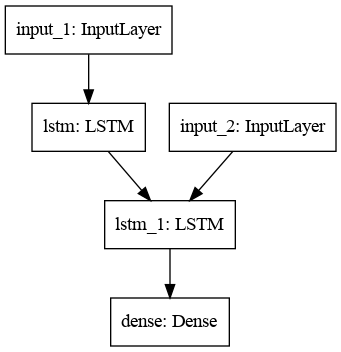

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png')

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 267264      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  267264      input_2[0][0]                    
                                                                 lstm[0][1]                   

## Train model

In [11]:
model.compile(
    optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = patience, 
                   verbose = 1, restore_best_weights = True)

log = model.fit(
    [ encoder_input_data, decoder_input_data ],
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

2021-10-05 16:36:50.103011: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2021-10-05 16:36:52.114234: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


110/110 [==============================] - 43s 366ms/step - loss: 1.3341 - accuracy: 0.3538 - val_loss: 1.3047 - val_accuracy: 0.3675
Epoch 2/1000
110/110 [==============================] - 39s 358ms/step - loss: 1.2878 - accuracy: 0.3797 - val_loss: 1.2460 - val_accuracy: 0.4166
Epoch 3/1000
110/110 [==============================] - 40s 360ms/step - loss: 1.2041 - accuracy: 0.4456 - val_loss: 1.1217 - val_accuracy: 0.5041
Epoch 4/1000
110/110 [==============================] - 40s 360ms/step - loss: 1.0350 - accuracy: 0.5539 - val_loss: 0.9287 - val_accuracy: 0.6104
Epoch 5/1000
110/110 [==============================] - 40s 368ms/step - loss: 0.8660 - accuracy: 0.6442 - val_loss: 0.7881 - val_accuracy: 0.6788
Epoch 6/1000
110/110 [==============================] - 41s 376ms/step - loss: 0.9953 - accuracy: 0.6179 - val_loss: 1.3846 - val_accuracy: 0.4345
Epoch 7/1000
110/110 [==============================] - 41s 375ms/step - loss: 0.8680 - accuracy: 0.6526 - val_loss: 0.5687 - val_a

110/110 [==============================] - 38s 348ms/step - loss: 1.2815 - accuracy: 0.3979 - val_loss: 1.2738 - val_accuracy: 0.4008
Epoch 57/1000
110/110 [==============================] - 38s 350ms/step - loss: 1.2694 - accuracy: 0.4041 - val_loss: 1.2653 - val_accuracy: 0.4072
Epoch 58/1000
110/110 [==============================] - 39s 353ms/step - loss: 1.2643 - accuracy: 0.4075 - val_loss: 1.2618 - val_accuracy: 0.4092
Epoch 59/1000
110/110 [==============================] - 38s 348ms/step - loss: 1.2614 - accuracy: 0.4091 - val_loss: 1.2612 - val_accuracy: 0.4106
Epoch 60/1000
110/110 [==============================] - 39s 355ms/step - loss: 1.2607 - accuracy: 0.4092 - val_loss: 1.2602 - val_accuracy: 0.4095
Epoch 61/1000
110/110 [==============================] - 41s 373ms/step - loss: 1.2596 - accuracy: 0.4100 - val_loss: 1.2587 - val_accuracy: 0.4094
Epoch 62/1000
110/110 [==============================] - 41s 373ms/step - loss: 1.2592 - accuracy: 0.4108 - val_loss: 1.2587 -

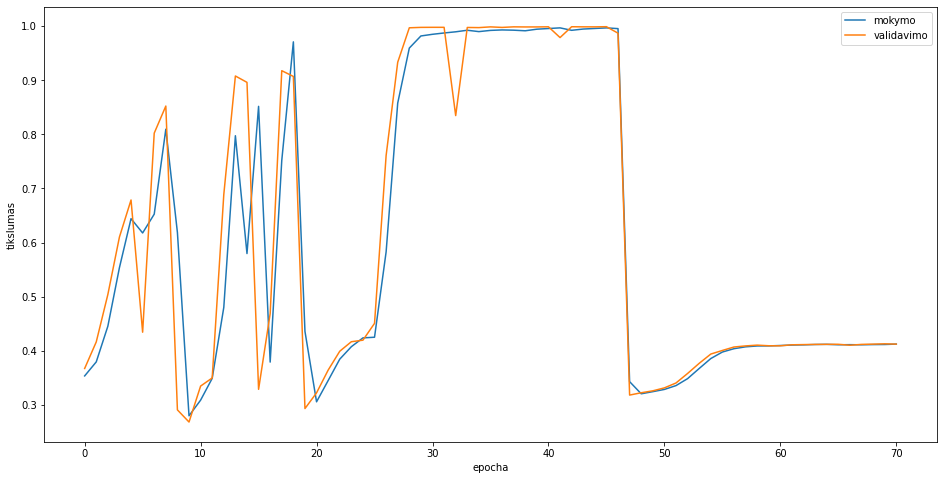

In [12]:
plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

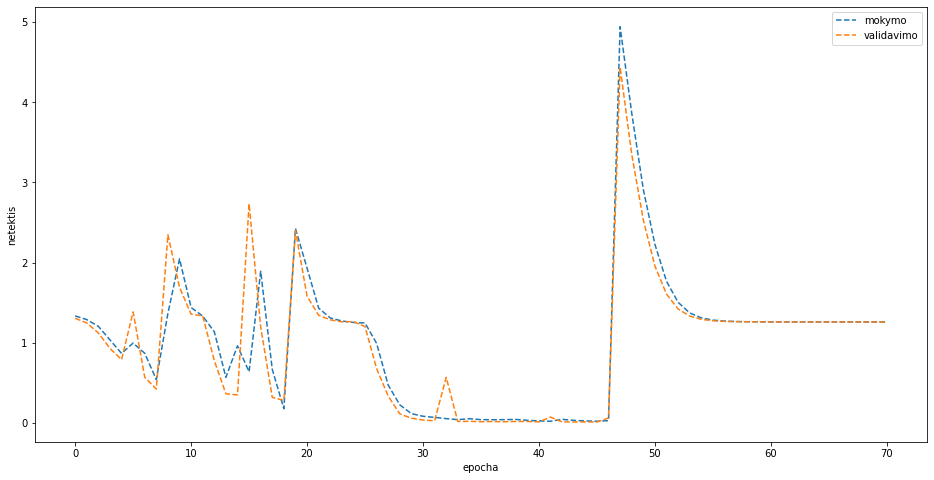

In [13]:
plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

# Save model
model.save("data/ncbi_02/model_256")

2021-10-05 17:23:55.442611: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_256/assets
